# Evaluation
This notebook will walk you step by step through the process of using the detection results files included in the zip folders of each pre-trained model.

## Prepare env

In [ ]:
!git clone https://github.com/aarcosg/traffic-sign-detection.git

Cloning into 'traffic-sign-detection'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 48 (delta 3), reused 0 (delta 0), pack-reused 37
Unpacking objects: 100% (48/48), done.


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from itertools import cycle
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import os
import copy

np.random.seed(1)

In [ ]:
os.chdir('/content/traffic-sign-detection')

In [ ]:
!wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip

In [ ]:
!unzip /content/traffic-sign-detection/FullIJCNN2013.zip -d /content/traffic-sign-detection/dataset/

In [ ]:
# import shutil
# shutil.rmtree(DATASET_PATH)

In [ ]:
EPSILON = 1e-5
# Load GTSDB validation images
CLASSES = ['prohibitory','mandatory','danger']
#Path to the German Traffic Sign Detection Benchmark dataset
DATASET_PATH = '/content/traffic-sign-detection/dataset/FullIJCNN2013/'
full_set = ['%05d.jpg' % x for x in range(900)]
valid_set = full_set[600:900]

In [ ]:
category_index = {1: {'id': 1, 'name': 'prohibitory'},
 2: {'id': 2, 'name': 'mandatory'},
 3: {'id': 3, 'name': 'danger'}}
categories = [{'id': 1, 'name': 'prohibitory'},
 {'id': 2, 'name': 'mandatory'},
 {'id': 3, 'name': 'danger'}]

## Load detection results

In [ ]:
# faster rcnn inception v2
!gdown https://drive.google.com/u/0/uc?id=1LRCSWIkX_i6ijScMfaxSte_5a_x9tjWF&export=download
!unzip /content/traffic-sign-detection/faster_rcnn_inception_v2.zip -d /content/traffic-sign-detection/models/faster_rcnn_inception_v2

In [ ]:
# ssd_inception_v2
!gdown https://drive.google.com/u/0/uc?id=1TKMd-wIZJ1aUcOhWburm2b6WgYnP0ZK6&export=download
!unzip /content/traffic-sign-detection/ssd_inception_v2.zip -d /content/traffic-sign-detection/models/ssd_inception_v2

In [ ]:
# ssd_mobilenet_v1
!gdown https://drive.google.com/u/0/uc?id=1U31RhUvE1Urr5Q92AJynMvl-oFBVRxxg&export=download
!unzip /content/traffic-sign-detection/ssd_mobilenet_v1.zip -d /content/traffic-sign-detection/models/ssd_mobilenet_v1

In [ ]:
# faster_rcnn_resnet_101
!gdown https://drive.google.com/u/0/uc?id=15OxyPlqyOOlUdsbUmdrexKLpHy1l5tP9&export=download
!unzip /content/traffic-sign-detection/faster_rcnn_resnet_101.zip -d /content/traffic-sign-detection/models/faster_rcnn_resnet_101

In [ ]:
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'
# MODEL_NAME = 'yolo_v2'

In [ ]:
MODEL_PATH = os.path.join('models', MODEL_NAME)
with open(os.path.join(MODEL_PATH, 'detections_output_result.pkl'), 'rb') as pickle_file:
    detections = pickle.load(pickle_file)

## Helper code

In [ ]:
def filter_val_detections(detections):
    fdetects = []
    for d in detections:
        if d['file'] in valid_set:
            fdetects.append(d)
    return fdetects

In [ ]:
def get_detection_by_filename(detections, filename):
    for detection in detections:
        if detection['file'] == filename:
            return detection

In [ ]:
def plot_rectangle(bbox,ax,class_name,edgecolor,confidence=None):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    left = xmin
    right = xmax
    top = ymin
    bot = ymax
    ax.add_patch(
        plt.Rectangle((left, top),
                      right-left,
                      bot-top, fill=False,
                      edgecolor=edgecolor, linewidth=2)
        )
    label = '{:s}:'.format(class_name)
    label += ' {0:.2f}%'.format(confidence)
    label_pos_y = ((bot - top) / 2) + top + 3.5
    label_pos_x = right+10
    if class_name == 'danger':
        label_pos_x = left
        label_pos_y = top - 9
    elif class_name == 'prohibitory':
        label_pos_x = left - 30
        label_pos_y = bot + 15
    ax.text(label_pos_x, label_pos_y,label,
            bbox=dict(facecolor=edgecolor, edgecolor=edgecolor, alpha=1),
            fontsize=11)

In [ ]:
def intersection(bbgt, bb):
    # determine the (x, y)-coordinates of the intersection rectangle
    ixmin = max(bbgt[0], bb[0])
    iymin = max(bbgt[1], bb[1])
    ixmax = min(bbgt[2], bb[2])
    iymax = min(bbgt[3], bb[3])
    
    # compute the area of intersection rectangle
    iw = max(ixmax - ixmin, 0)
    ih = max(iymax - iymin, 0)
    intersArea = iw * ih
    
    return intersArea

In [ ]:
def union(bbgt, bb, intersArea):
    # compute the area of both the prediction and ground-truth rectangles
    boxgtArea = (bbgt[2] - bbgt[0]) * (bbgt[3] - bbgt[1])
    boxArea = (bb[2] - bb[0]) * (bb[3] - bb[1])
    unionArea = boxgtArea + boxArea - intersArea
    return unionArea

In [ ]:
# Returns the intersection over union of two rectangles, a and b, where each is an array [x,y,w,h]
def compute_iou(bbgt, bb):
    overlaps = np.zeros(len(bbgt))
    for i,gtBbox in enumerate(bbgt):
        inters = float(intersection(gtBbox, bb))
        uni = union(gtBbox, bb, inters)
        iou = inters/uni
        overlaps[i] = iou
    ioumax = np.max(overlaps)
    jmax = np.argmax(overlaps)
    return ioumax, jmax

In [ ]:
def voc_ap(rec, prec):
    # correct AP calculation (from VOC 2010 challenge)
    # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf (page 12)
    
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [ ]:
def match_gts_and_compute_prec_recall_ap(cls,detections,iouthresh=0.5):
    """
    INPUTS:
    -BB: predicted bounding boxes
    -BBGT: predicted bounding boxes, BBGT = R['bbox'].astype(float)
    OUTPUTS:
    -rec: recall
    -prec: precision
    -ap: average precision
    A bounding box reported by an algorithm is considered
    correct if its area intersection over union with a ground 
    truth bounding box is beyond 50%. If a lot of closely overlapping 
    bounding boxes hitting on a same ground truth, only one of
    them is counted as correct, and all the others are treated as false alarms
    """
    # print('IoU threshold set to: {:.2f}'.format(iouthresh))
    GT_OBJECTS = {}
    BB = []
    BB_im_ids = []
    BB_confidences = []
    n_gt_bboxes = 0
    
    for dId,d in enumerate(detections):
        BBGT = []
        for i in range(len(d['gt_bboxes'])):
            if d['gt_classes'][i] == cls:
                BBGT.append(d['gt_bboxes'][i])
                n_gt_bboxes += 1
        GT_OBJECTS[d['file']] = {
            'bboxes' : np.asarray(BBGT),
            'detected?' : [False] * len(BBGT)
        }
        for i in range(len(d['pred_bboxes'])):
            if d['pred_classes'][i] == cls:
                BB.append(d['pred_bboxes'][i])
                BB_im_ids.append(d['file'])
                BB_confidences.append(d['confidences'][i])
      
    if n_gt_bboxes == 0:
        return None,None,None
    
    BB = np.asarray(BB)
    BB_confidences = np.asarray(BB_confidences)
    
    # sort by confidence
    if len(BB) > 0:
        sorted_ind = np.argsort(-BB_confidences)
        sorted_scores = np.sort(-BB_confidences)
        BB = BB[sorted_ind, :]
        BB_im_ids = [BB_im_ids[x] for x in sorted_ind]            
    
    num_detections = len(BB_im_ids)
    tp = np.zeros(num_detections)
    fp = np.zeros(num_detections)
    avg_overlap = []
    
    for d in range(num_detections):
        gt_info = GT_OBJECTS[BB_im_ids[d]]
        bb = BB[d, :].astype(float)
        BBGT = gt_info['bboxes'].astype(float)
        ioumax = -np.inf
        
        if BBGT.size > 0:
            # compute intersection over union
            ioumax, jmax = compute_iou(BBGT,bb)
        if ioumax > iouthresh:
            if not gt_info['detected?'][jmax]:
                tp[d] = 1. # true positive
                gt_info['detected?'][jmax] = 1
                avg_overlap.append(ioumax)
            else:
                fp[d] = 1. # false positive (multiple detection)
        else:
            fp[d] = 1. # false positive
        
    avg_overlap = np.array(avg_overlap) if len(avg_overlap) > 0 else np.array([0])
    
    # compute precision recall
    fp = np.cumsum(fp) if len(fp) > 0 else np.array([0])
    tp = np.cumsum(tp) if len(tp) > 0 else np.array([0])
    
    fn = n_gt_bboxes - tp[-1]
    
    rec = tp / np.maximum(tp + fn, np.finfo(np.float64).eps)
    # avoid divide by zero in case the first detection matches a difficult ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    
    ap = voc_ap(rec, prec)
    
    # print("TP: {}".format(tp[-1]))
    # print("FP: {}".format(fp[-1]))
    # print("FN: {}".format(fn))
    class_name = category_index[cls]['name']
    # print('Avg. overlap for {} = {:.4f}'.format(class_name, np.mean(avg_overlap)))
    
    # print('Precision for {} = {:.4f}'.format(class_name, prec[-1]))
    # print('Recall for {} = {:.4f}'.format(class_name, rec[-1]))
    
    return rec, prec, ap

In [ ]:
def plot_precision_recall(prec, recall, ap):
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [recall[-1]]))
    mpre = np.concatenate(([prec[0]], prec, [0.]))
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(mrec, mpre, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AP={0:0.2f}'.format(ap))
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
def compute_mean_average_precision_COCO2016(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """

#     plotDets(detections)
    aps_class = []
    for category in categories:
        aps_iou = []
        for iouthresh in np.arange(.5, 1, .05):
            rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh)
            if ap is not None:
                aps_iou += [ap]
                # print('AP for {} and IoU threshold {:.2f} = {:.4f}'.format(category['name'], iouthresh, ap))
            # plot_precision_recall(prec, rec, ap)
        aps_class += [np.mean(aps_iou)] 
        # print('Mean AP for {} = {:.4f}'.format(category['name'],np.mean(aps_iou)))
        
    print('Mean AP = {:.4f}'.format(np.mean(aps_class)))
    print('~~~~~~~~')
    print('Results:')
    # for ap in aps_class:
    #     print('{:.3f}'.format(ap))
    # print('{:.3f}'.format(np.mean(aps_class)))
    # mAP = np.mean(aps_class)
    # return mAP

## Filter detections

In [ ]:
detections = filter_val_detections(detections)

## Eval Microsoft COCO 2016

In [ ]:
compute_mean_average_precision_COCO2016(detections)

Mean AP = 0.8861
~~~~~~~~
Results:


## Plot detections

In [ ]:
CLASSES_COLOR = ['DarkOrange','Aqua','Chartreuse']

def plot_dets(detection, model_name):
    path = detection['file']
    path = path[:path.rfind('jpg')] + 'ppm'

    fig, ax = plt.subplots(figsize=(20, 20))
    image = np.array(Image.open(DATASET_PATH + path))
    image = np.squeeze(image)
    imWidth = image.shape[1]
    imHeight = image.shape[0]
    for j in range(len(detection['pred_bboxes'])):
        pred_class = detection['pred_classes'][j]
        bbox = detection['pred_bboxes'][j]
        confidence = detection['confidences'][j] * 100
        plot_rectangle(bbox,ax,category_index[pred_class]['name'],CLASSES_COLOR[pred_class-1], confidence)
    plt.axis('off')
    ax.imshow(image, aspect='equal')

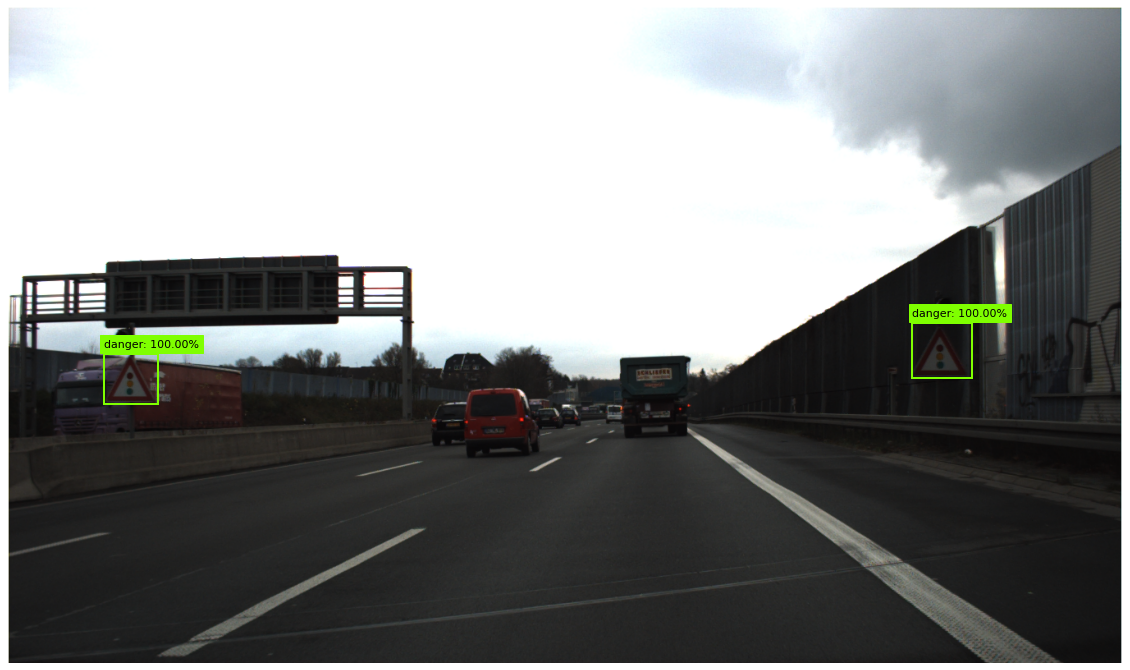

In [ ]:
sample = get_detection_by_filename(detections, '00867.jpg')
plot_dets(sample, MODEL_NAME)